In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [59]:
sales = pd.read_csv("Data2.csv")
sales['sales_date'] = pd.to_datetime(sales["sales_date"])

In [60]:
sales['sales_date'] = sales['sales_date'].dt.to_period("M")
monthly_sales = sales.groupby('sales_date').sum().reset_index()
monthly_sales['sales_date'] = monthly_sales['sales_date'].dt.to_timestamp()

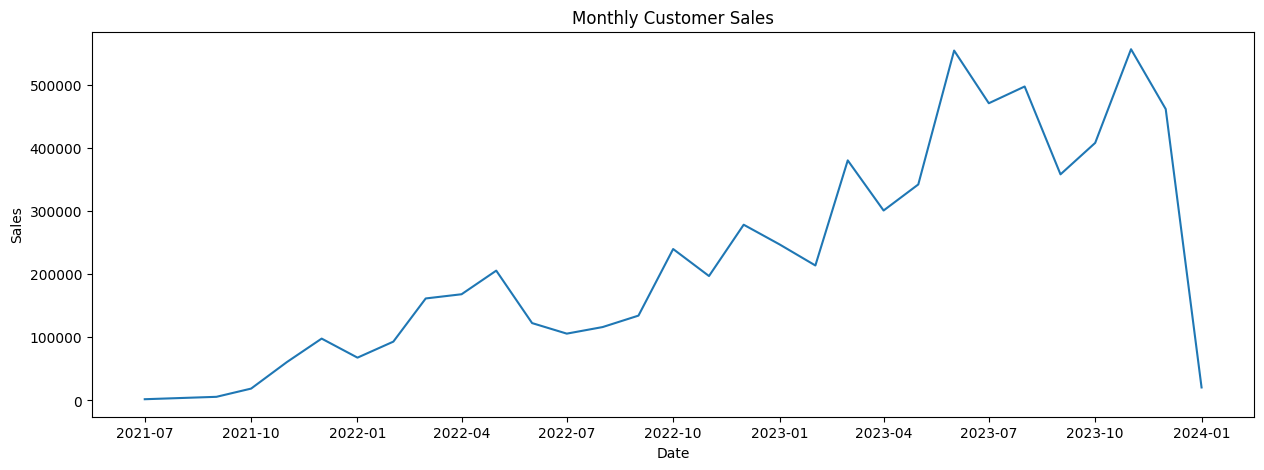

In [61]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['sales_date'], monthly_sales['sales_amount'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [62]:
monthly_sales['sales_diff'] = monthly_sales['sales_amount'].diff()
monthly_sales = monthly_sales.dropna()

In [63]:
supervised_data = monthly_sales.drop(['sales_date', 'sales_amount'], axis=1)

In [64]:
# Prepare Supervised Data
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [65]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [66]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [67]:
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

In [68]:
sales_dates = monthly_sales['sales_date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['sales_amount'][-13:].to_list()

Create Random Forrest Regressor Model

In [69]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pre = rf_model.predict(X_test)

rf_pre = rf_pre.reshape(-1, 1)
rf_pre_test_set = np.concatenate([rf_pre, X_test], axis=1)
rf_pre_test_set = scaler.inverse_transform(rf_pre_test_set)

In [70]:
result_list = []
for index in range(0, len(rf_pre_test_set)):
    result_list.append(rf_pre_test_set[index][0] + act_sales[index])
rf_pre_series = pd.Series(result_list, name="RandomForest Prediction")
predict_df = predict_df.merge(rf_pre_series, left_index=True, right_index=True)

In [71]:
rf_mse = np.sqrt(mean_squared_error(predict_df['RandomForest Prediction'], monthly_sales['sales_amount'][-12:]))
rf_mae = mean_absolute_error(predict_df['RandomForest Prediction'], monthly_sales['sales_amount'][-12:])
rf_r2 = r2_score(predict_df['RandomForest Prediction'], monthly_sales['sales_amount'][-12:])
print("RandomForest MSE: ", rf_mse)
print("RandomForest MAE: ", rf_mae)
print("RandomForest R2: ", rf_r2)

RandomForest MSE:  183001.59487944507
RandomForest MAE:  133954.551625
RandomForest R2:  -1.7441757087145993


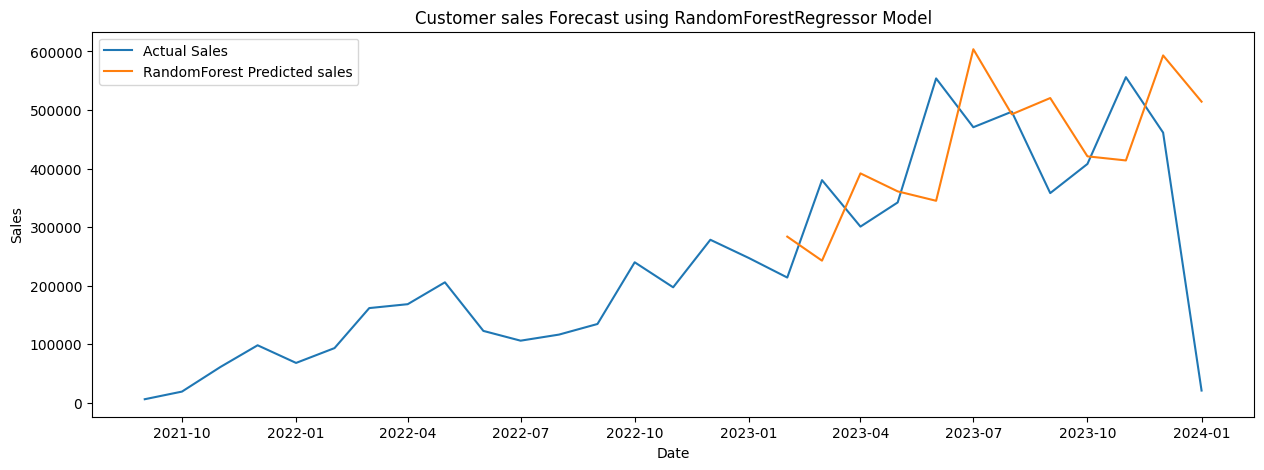

In [72]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['sales_date'], monthly_sales['sales_amount'])
plt.plot(predict_df['sales_date'], predict_df['RandomForest Prediction'])
plt.title("Customer sales Forecast using RandomForestRegressor Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'RandomForest Predicted sales'])
plt.show()